<a href="https://www.kaggle.com/code/averma111/pytorch-tabular-regression?scriptVersionId=127746181" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

### Data wine data set

In [3]:
df = pd.read_csv("/kaggle/input/winequality/winequality-red.csv")
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Plot the wine quality to check variety


<AxesSubplot:xlabel='quality', ylabel='count'>

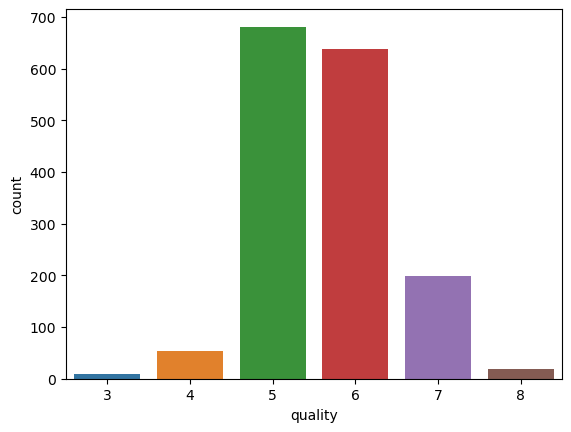

In [4]:
sns.countplot(x='quality',data=df)

### Select features as X and labels as y from dataset

In [5]:
X = df.iloc[:, 0:-1]
y = df.iloc[:, -1]

### Splitting the dataset between test train and valiation


In [6]:
from sklearn.model_selection import train_test_split
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=69)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.1, stratify=y_trainval, random_state=21)

### Since pytorch model needs data between (0,1) we are going to scale the data


In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_train, y_train = np.array(X_train), np.array(y_train)
X_val, y_val = np.array(X_val), np.array(y_val)
X_test, y_test = np.array(X_test), np.array(y_test)

### Get the wine class distribution 

In [9]:
def get_class_distribution(obj):
    count_dict = {
        "rating_3": 0,
        "rating_4": 0,
        "rating_5": 0,
        "rating_6": 0,
        "rating_7": 0,
        "rating_8": 0,
    }
    
    for i in obj:
        if i == 3: 
            count_dict['rating_3'] += 1
        elif i == 4: 
            count_dict['rating_4'] += 1
        elif i == 5: 
            count_dict['rating_5'] += 1
        elif i == 6: 
            count_dict['rating_6'] += 1
        elif i == 7: 
            count_dict['rating_7'] += 1  
        elif i == 8: 
            count_dict['rating_8'] += 1              
        else:
            print("Check classes.")
            
    return count_dict

### Validating the data distribution among train test and validation dataset

Text(0.5, 1.0, 'Class Distribution in Test Set')

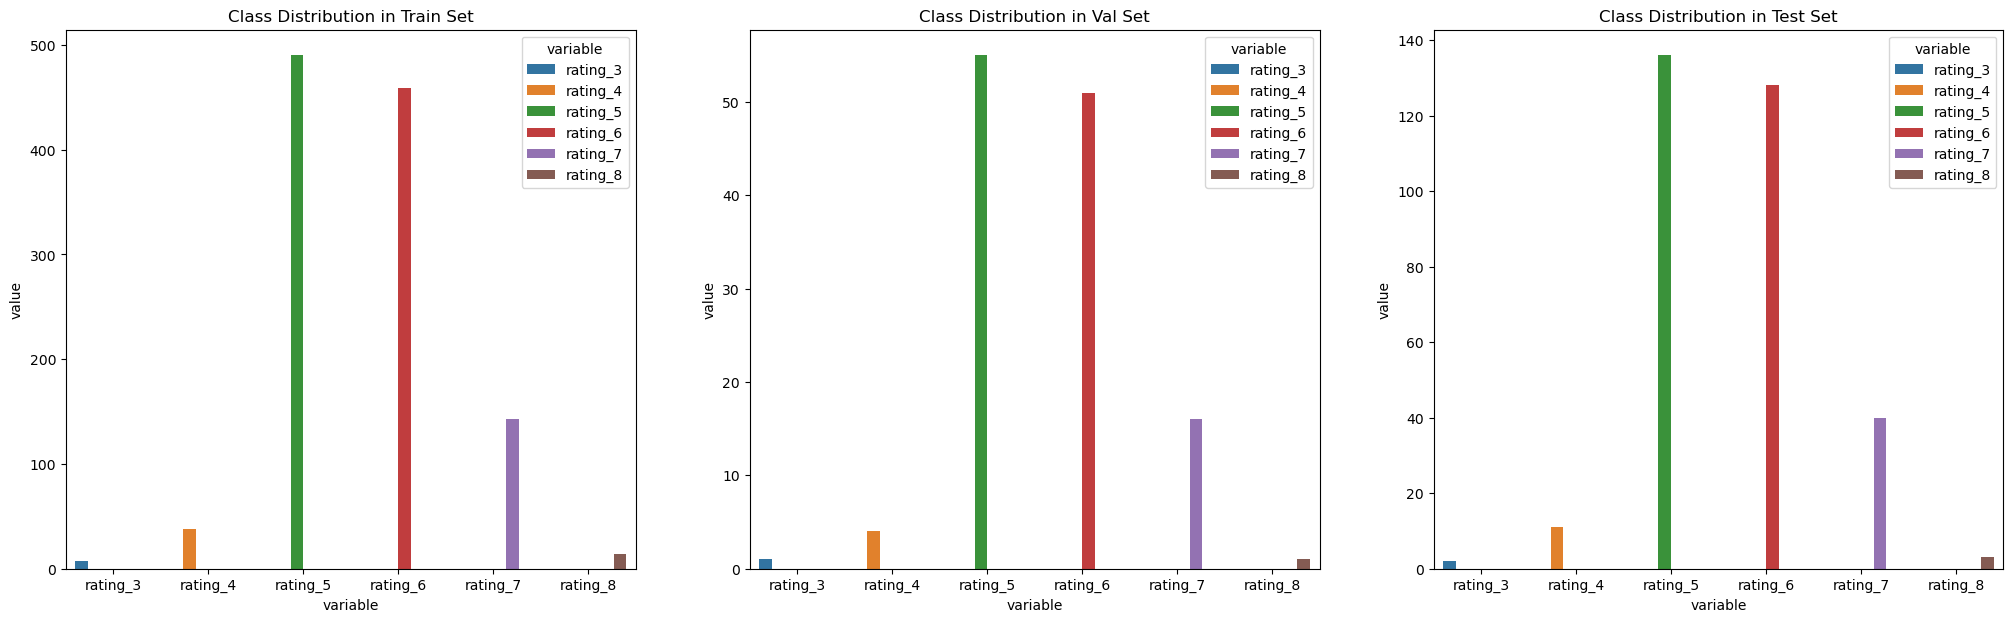

In [10]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,7))
# Train
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_train)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[0]).set_title('Class Distribution in Train Set')
# Val
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_val)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[1]).set_title('Class Distribution in Val Set')
# Test
sns.barplot(data = pd.DataFrame.from_dict([get_class_distribution(y_test)]).melt(), x = "variable", y="value", hue="variable",  ax=axes[2]).set_title('Class Distribution in Test Set')

In [11]:
y_train, y_test, y_val = y_train.astype(float), y_test.astype(float), y_val.astype(float)

### Creating the dataset class 

In [12]:
import torch
from torch.utils.data import Dataset, DataLoader
class RegressionDataset(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)
train_dataset = RegressionDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
val_dataset = RegressionDataset(torch.from_numpy(X_val).float(), torch.from_numpy(y_val).float())
test_dataset = RegressionDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float())

### Defining the hyper parameters

In [13]:
EPOCHS = 150
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_FEATURES = len(X.columns)

### Loading the dataset into Dataload for interation

In [14]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1)

### Basline model 

In [15]:
class MultipleRegression(torch.nn.Module):
    def __init__(self, num_features):
        super(MultipleRegression, self).__init__()
        
        self.layer_1 = torch.nn.Linear(num_features, 16)
        self.layer_2 = torch.nn.Linear(16, 32)
        self.layer_3 = torch.nn.Linear(32, 16)
        self.layer_out = torch.nn.Linear(16, 1)
        self.relu = torch.nn.ReLU()
        
    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

    def predict(self, test_inputs):
        x = self.relu(self.layer_1(test_inputs))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_out(x)
        return (x)

### Checking if the GPU is available

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Instantiating the model and defining loss and optimizer 

In [19]:
model = MultipleRegression(NUM_FEATURES)
model.to(device)
print(model)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

MultipleRegression(
  (layer_1): Linear(in_features=11, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=16, bias=True)
  (layer_out): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)


### A dictionary to collect statistics

In [20]:
loss_stats = {
    'train': [],
    "val": []
}

### Let the traning begin :)

In [23]:
from tqdm.notebook import tqdm
print("Begin training.")
for e in tqdm(range(1, EPOCHS+1)):
    
    # TRAINING
    train_epoch_loss = 0
    model.train()
    for X_train_batch, y_train_batch in train_loader:
        X_train_batch, y_train_batch = X_train_batch.to(device), y_train_batch.to(device)
        optimizer.zero_grad()
        
        y_train_pred = model(X_train_batch)
        
        train_loss = criterion(y_train_pred, y_train_batch.unsqueeze(1))
        
        train_loss.backward()
        optimizer.step()
        
        train_epoch_loss += train_loss.item()
        
        
    # VALIDATION    
    with torch.no_grad():
        
        val_epoch_loss = 0
        
        model.eval()
        for X_val_batch, y_val_batch in val_loader:
            X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
            
            y_val_pred = model(X_val_batch)
                        
            val_loss = criterion(y_val_pred, y_val_batch.unsqueeze(1))
            
            val_epoch_loss += val_loss.item()
        loss_stats['train'].append(train_epoch_loss/len(train_loader))
        loss_stats['val'].append(val_epoch_loss/len(val_loader))                              
    
    print(f'Epoch {e+0:03}: | Train Loss: {train_epoch_loss/len(train_loader):.5f} | Val Loss: {val_epoch_loss/len(val_loader):.5f}')

Begin training.


  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 001: | Train Loss: 29.27196 | Val Loss: 28.31116
Epoch 002: | Train Loss: 27.58426 | Val Loss: 26.12046
Epoch 003: | Train Loss: 24.43292 | Val Loss: 21.56551
Epoch 004: | Train Loss: 18.05536 | Val Loss: 12.95712
Epoch 005: | Train Loss: 8.02206 | Val Loss: 2.70550
Epoch 006: | Train Loss: 1.25917 | Val Loss: 1.18329
Epoch 007: | Train Loss: 0.95673 | Val Loss: 0.80990
Epoch 008: | Train Loss: 0.79274 | Val Loss: 0.78286
Epoch 009: | Train Loss: 0.77121 | Val Loss: 0.76834
Epoch 010: | Train Loss: 0.75115 | Val Loss: 0.74054
Epoch 011: | Train Loss: 0.73029 | Val Loss: 0.72306
Epoch 012: | Train Loss: 0.71332 | Val Loss: 0.70386
Epoch 013: | Train Loss: 0.69805 | Val Loss: 0.68358
Epoch 014: | Train Loss: 0.68326 | Val Loss: 0.66825
Epoch 015: | Train Loss: 0.67055 | Val Loss: 0.64881
Epoch 016: | Train Loss: 0.65522 | Val Loss: 0.63601
Epoch 017: | Train Loss: 0.64714 | Val Loss: 0.61827
Epoch 018: | Train Loss: 0.63355 | Val Loss: 0.60653
Epoch 019: | Train Loss: 0.62082 | Val

### Plotting the valiation loss for training dataset

Text(0.5, 1.0, 'Train-Val Loss/Epoch')

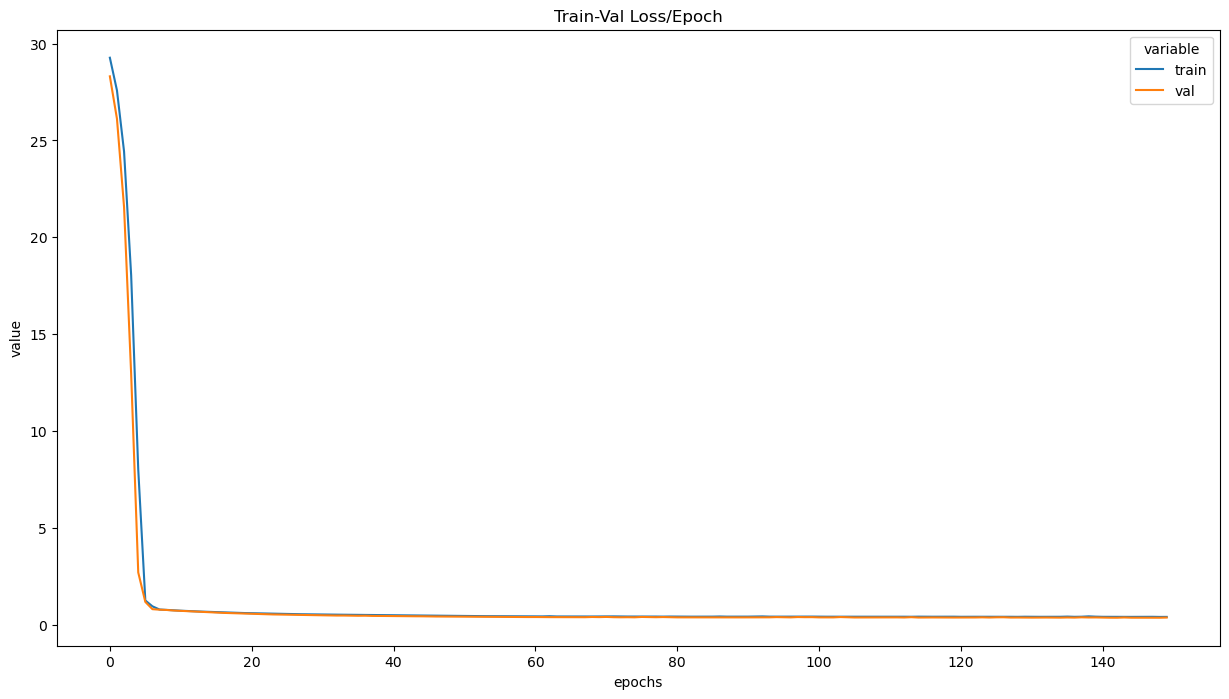

In [24]:
train_val_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
plt.figure(figsize=(15,8))
sns.lineplot(data=train_val_loss_df, x = "epochs", y="value", hue="variable").set_title('Train-Val Loss/Epoch')

### Testing the model with test dataset

In [25]:
y_pred_list = []
with torch.no_grad():
    model.eval()
    for X_batch, _ in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_pred_list.append(y_test_pred.cpu().numpy())
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

### Checking the model accuracy 

In [27]:
from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred_list)
r_square = r2_score(y_test, y_pred_list)
print("Mean Squared Error :",mse)
print("R^2 :",r_square)

Mean Squared Error : 0.40383437474328543
R^2 : 0.3741655067844236
